In [46]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
%matplotlib inline

import pandas_datareader as pdr

import requests_cache
session = requests_cache.CachedSession(cache_name='stocks-cache', backend='sqlite')

In [2]:
ts = pdr.DataReader(
    'RUB=X',
    start='2000-01-01',
    end='2020-10-10',
    data_source='yahoo',
    session=session
).Close

ts.loc[ts < 1] = None

ts = ts.fillna(method='ffill').rename('RUB=X')

ts.index = pd.to_datetime(ts.index)

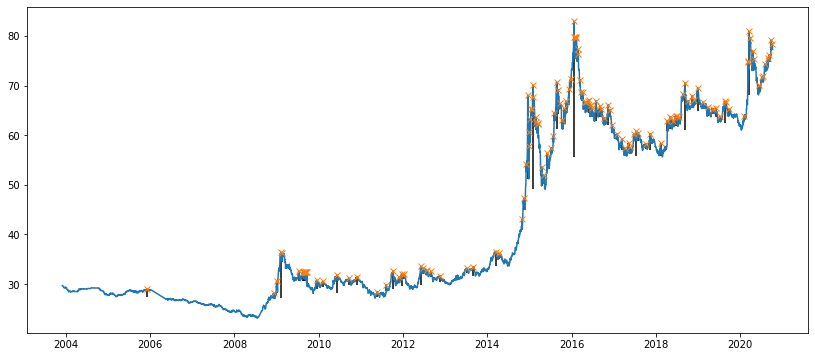

In [9]:
peaks, props = find_peaks(ts, prominence=1)
prominences = props['prominences']
plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts)
plt.plot(ts[peaks].index, ts[peaks], 'x')
plt.vlines(x=ts[peaks].index, ymin=ts[peaks] - prominences, ymax=ts[peaks], colors='black');

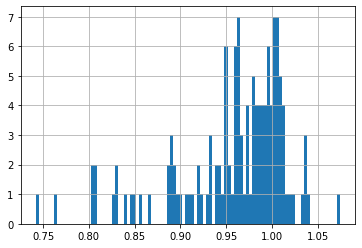

In [10]:
gains = (ts/ts.shift(1).rolling(90, min_periods=0).max())[peaks]
gains.hist(bins=100);

In [11]:
r = {}
r['>1'] = (gains > 1).sum()/len(gains)
r['<1,>.9'] = (gains > .9).sum()/len(gains)-r['>1']
r['<.9'] = (gains < .9).sum()/len(gains)
pd.Series(r)



>1        0.265152
<1,>.9    0.560606
<.9       0.174242
dtype: float64

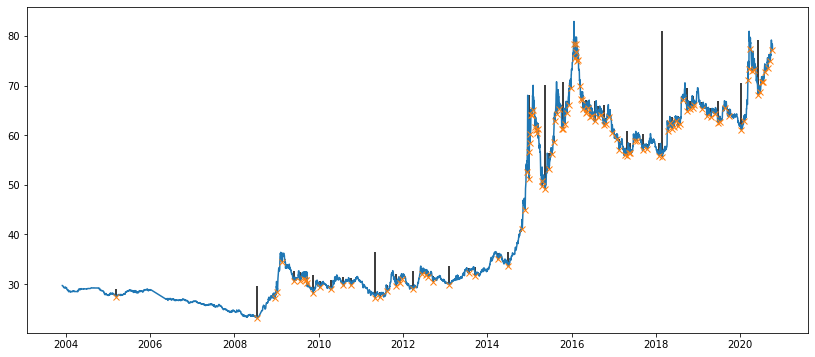

In [12]:
peaks, props = find_peaks(-ts, prominence=1)
prominences = props['prominences']
plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts)
plt.plot(ts[peaks].index, ts[peaks], 'x')
plt.vlines(x=ts[peaks].index, ymin=ts[peaks], ymax=ts[peaks] + prominences, colors='black');

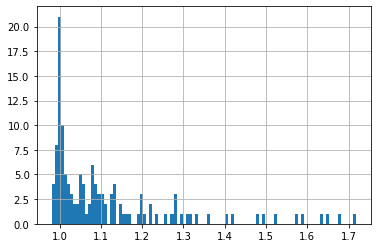

In [13]:
gains = (ts/ts.shift(1).rolling(90, min_periods=0).min())[peaks]
gains.hist(bins=100);

In [14]:
r = {}
r['<1'] = (gains < 1).sum()/len(gains)
r['>1,<1.1'] = (gains < 1.1).sum()/len(gains)-r['<1']
r['>1.1'] = (gains > 1.1).sum()/len(gains)
pd.Series(r)


<1         0.207692
>1,<1.1    0.453846
>1.1       0.338462
dtype: float64

In [15]:
ts = pdr.DataReader(
    'GC=F',
    start='2000-01-01',
    end='2020-10-10',
    data_source='yahoo',
    session=session
).Close

ts.loc[ts < 1] = None

ts = ts.fillna(method='ffill').rename('GC=F')

ts.index = pd.to_datetime(ts.index)

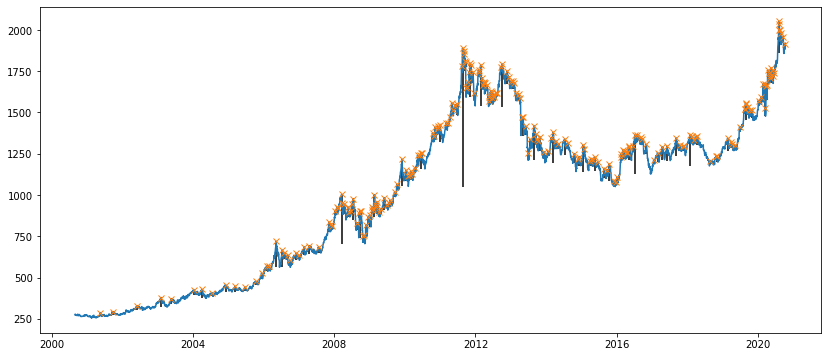

In [16]:
peaks, props = find_peaks(ts, prominence=20)
prominences = props['prominences']
plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts)
plt.plot(ts[peaks].index, ts[peaks], 'x')
plt.vlines(x=ts[peaks].index, ymin=ts[peaks] - prominences, ymax=ts[peaks], colors='black');

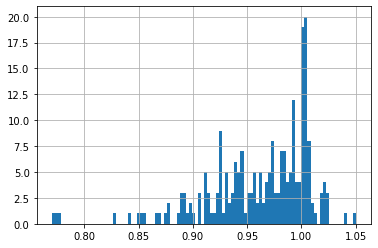

In [17]:
gains = (ts/ts.shift(1).rolling(90, min_periods=0).max())[peaks]
gains.hist(bins=100);

In [19]:
r = {}
r['>1'] = (gains > 1).sum()/len(gains)
r['<1,>.9'] = (gains > .9).sum()/len(gains)-r['>1']
r['<.9'] = (gains < .9).sum()/len(gains)
pd.Series(r)

>1        0.268722
<1,>.9    0.629956
<.9       0.101322
dtype: float64

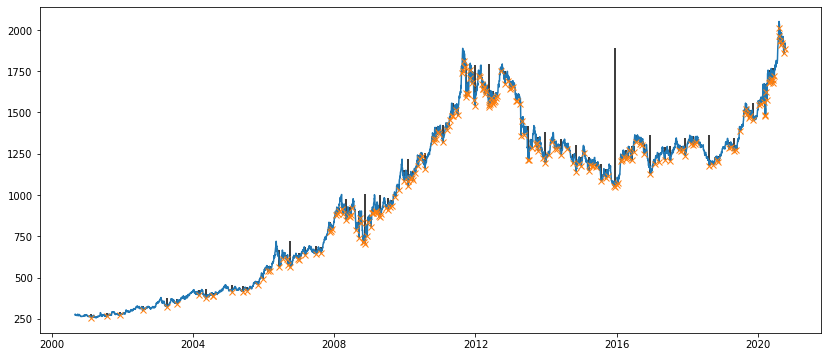

In [20]:
peaks, props = find_peaks(-ts, prominence=20)
prominences = props['prominences']
plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts)
plt.plot(ts[peaks].index, ts[peaks], 'x')
plt.vlines(x=ts[peaks].index, ymin=ts[peaks], ymax=ts[peaks] + prominences, colors='black');

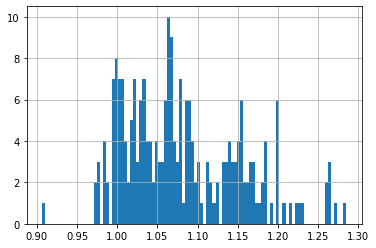

In [21]:
gains = (ts/ts.shift(1).rolling(90, min_periods=0).min())[peaks]
gains.hist(bins=100);

In [22]:
r = {}
r['<1'] = (gains < 1).sum()/len(gains)
r['>1,<1.1'] = (gains < 1.1).sum()/len(gains)-r['<1']
r['>1.1'] = (gains > 1.1).sum()/len(gains)
pd.Series(r)

<1         0.114035
>1,<1.1    0.557018
>1.1       0.328947
dtype: float64

In [47]:
ts = pdr.DataReader(
    'GC=F',
    start='2000-01-01',
    end='2020-10-10',
    data_source='yahoo',
    session=session
).Close

ts.loc[ts < 1] = None

ts = ts.fillna(method='ffill').rename('GC=F')

ts.index = pd.to_datetime(ts.index)

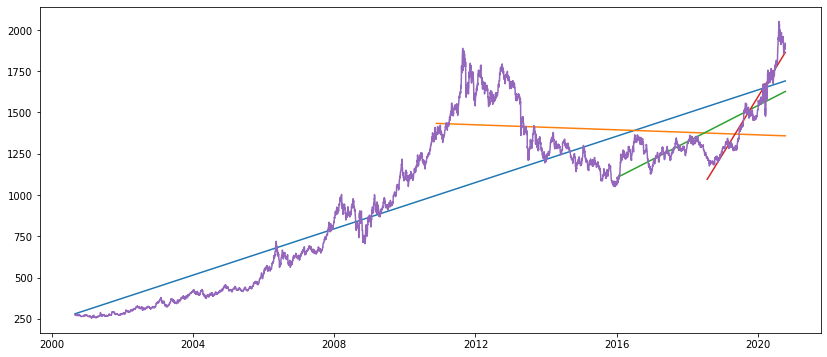

In [48]:
preds = []
for i in range(0, 4):
    tsr = ts[len(ts) - int(len(ts)/2**i):]
    days = (tsr.index - datetime(1970,1,1)).days
    m, b = np.polyfit(days, tsr, 1)
    pred = days*m+b
    preds.append((tsr.index, pred))

plt.figure(figsize=(14, 6))

for idx, pred in preds:
    plt.plot(idx, pred)

plt.plot(ts.index, ts);